# Making a panel of structures

In [1]:
# import Python modules

import os

from IPython.display import display, Image, HTML

import matplotlib.pyplot as plt

import nglview

import pandas as pd

import yaml

from dmslogo import facet_plot
from dms_struct.colorschemes import ValueToColorMap
from dms_struct.struct_widget import colored_struct

In [2]:
# This cell is tagged `parameters` to enable papermill parameterization
# See: https://papermill.readthedocs.io/en/latest/usage-parameterize.html

data_csv = 'data/Lee_serum_mapping.csv'  # CSV file with data to plot
serum_group = 'human'  # plot only this `serum_group` in `data_csv`, or `None`
mut_metric = 'mutdiffsel'  # mutation-level selection metric
site_metric = 'positive_diffsel'  # site-level selection metric

outdir = './structure_images/'  # output directory for structure images
quality_factor = 3  # quality of PNG files, 1 = low, 4 = high

pdb = '4o5n'  # PDB ID
# orientation of structure: https://github.com/arose/nglview/issues/785#issuecomment-487409212
orientation = [113.5, 44.09, 180.08, 0, -185.38, 23.99, 110.97, 0,
               2.63, -211.51, 50.12, 0, -34.66, 25.44, 46.9, 1]

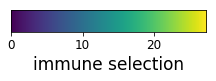

In [3]:
# read the data
data = pd.read_csv(data_csv)

# filter serum group if applicable
if serum_group:
    data = data.query('serum_group == @serum_group')

# get mutation-level data for logo plot plotting
mut_df = (data
          [['serum', 'isite', 'site', 'pdb_chain', 'pdb_site', 'zoom_site',
            'wildtype', 'mutation', mut_metric, site_metric]]
          .assign(site=lambda x: x['site'].astype('str'),
                  site_label=lambda x: x['wildtype'] + x['site'],
                  serum_spaces=lambda x: x['serum'].str.replace('-', ' '))
          )
# get mapper to map site metric to color
colormapper = ValueToColorMap(mut_df[site_metric].min(),
                              mut_df[site_metric].max())

# use the site metric to assign the colors
mut_df = mut_df.assign(color=lambda x: (x[site_metric]
                                        .apply(colormapper.val_to_color)))

# get site level data for structure images
site_df = (mut_df
           [['serum', 'pdb_chain', 'pdb_site', 'zoom_site', 'color']]
           .drop_duplicates()
           )

# show the scale bar
fig, _ = colormapper.scale_bar(label='immune selection',
                               orientation='horizontal')
display(fig)
plt.close(fig)

In [4]:
%%capture
# `%%capture` prevents plots from being shown

# get logo plots for each serum
dy = 0.055 * (colormapper.maxvalue - colormapper.minvalue)  # extra for y-limits
logoplots = {}
for serum, serum_df in mut_df.groupby('serum', sort=False):
    fig, _ = facet_plot(serum_df,
                        gridrow_col='serum_spaces',
                        x_col='isite',
                        show_col='zoom_site',
                        draw_line_kwargs={'height_col': site_metric,
                                          'xtick_col': 'site',
                                          'ylabel': 'immune selection'},
                        draw_logo_kwargs={'letter_col': 'mutation',
                                          'letter_height_col': mut_metric,
                                          'xtick_col': 'site_label',
                                          'color_col': 'color',
                                          'xlabel': 'site',
                                          'ylabel': 'immune selection',
                                          'clip_negative_heights': True},
                        line_titlesuffix='site-level selection',
                        logo_titlesuffix='mutation-level selection',
                        share_ylim_across_rows=False,
                        share_xlabel=True,
                        share_ylabel=True,
                        height_per_ax=2,
                        set_ylims=(-dy, colormapper.maxvalue + dy)
                        )
    logoplots[serum] = fig

In [5]:
# get structure widgets for each serum
widgets = {}
for serum, serum_df in site_df.groupby('serum', sort=False):
    w = colored_struct(pdb=pdb,
                       prop_df=serum_df,
                       chain_col='pdb_chain',
                       site_col='pdb_site',
                       highlight_col='zoom_site',
                       orientation=orientation,
                       )
    widgets[serum] = w

------------------------ 2010 age 21 ------------------------


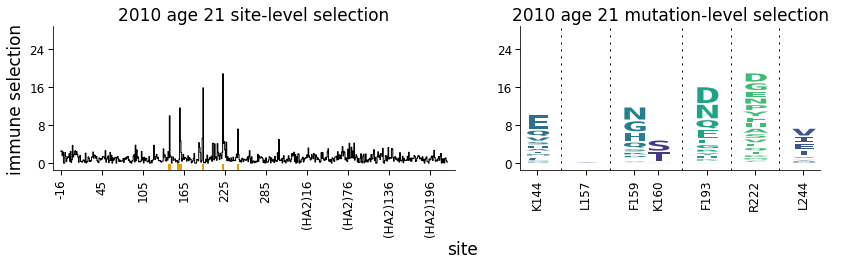

NGLWidget()

------------------------ 2009 age 53a ------------------------


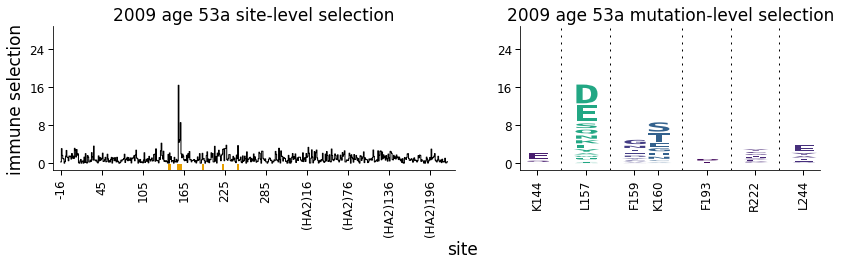

NGLWidget()

------------------------ 2009 age 53b ------------------------


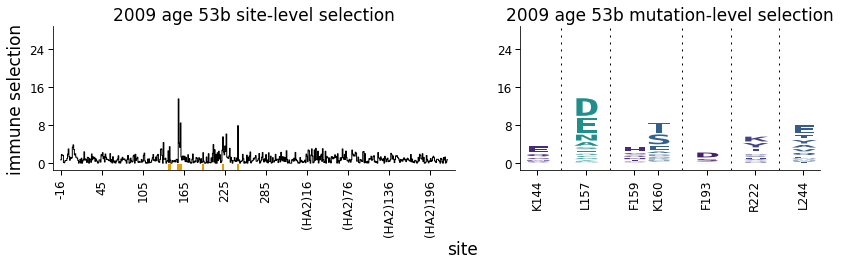

NGLWidget()

------------------------ 2009 age 64 ------------------------


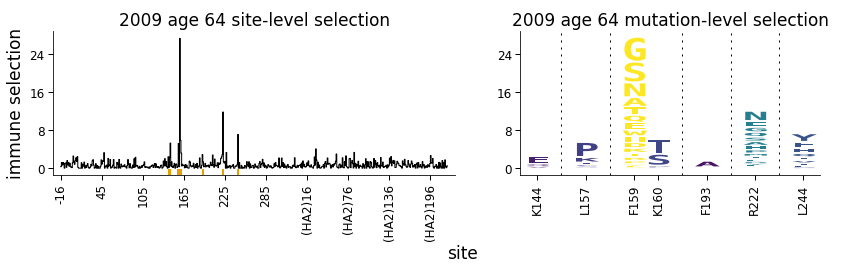

NGLWidget()

------------------------ 2009 age 65 ------------------------


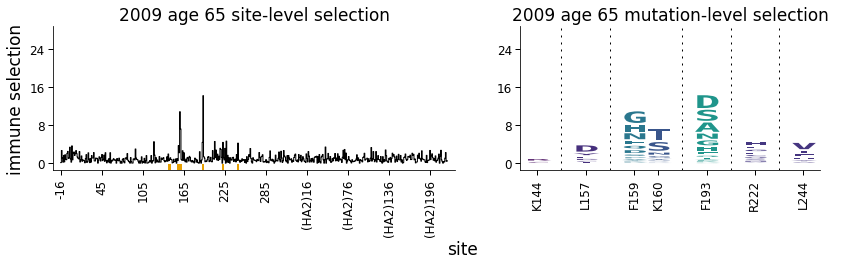

NGLWidget()

In [6]:
# show logo plots and widget for each serum
for serum, logofig in logoplots.items():
    print('-' * 24 + f" {serum.replace('-', ' ')} " + '-' * 24)
    display(logofig)
    display(widgets[serum])

In [ ]:
# save HTML images; wait until widget rendering completes before running
# https://github.com/arose/nglview/issues/802
os.makedirs(outdir, exist_ok=True)

for serum, w in widgets.items():
    html_file = os.path.join(outdir, f"{serum}.html")
    nglview.write_html(html_file, [w])

In [ ]:
# save PNG images: https://github.com/arose/nglview/issues/785#issuecomment-492083727
# Note commands in this cell and next two need to be run in separate cells.
# Wait for wdiget rendering to complete before running.

for serum, w in widgets.items():
    w.render_image(antialias=False, factor=quality_factor, trim=True)
    w.center()

In [ ]:
images = {}
for serum, w in widgets.items():
    images[serum] = w._display_image()

In [ ]:
png_files = {}
for serum, image in images.items():
    png_file = os.path.join(outdir, f"{serum}.png")
    with open(png_file, 'wb') as f:
        f.write(image.data)
    png_files[serum] = png_file

In [ ]:
# save PNG of scale bar
fig, _ = colormapper.scale_bar(label=f"immune selection",
                               orientation='vertical')
scalebar_png = os.path.join(outdir, 'scalebar.png')
fig.savefig(scalebar_png, dpi=300, bbox_inches='tight')
plt.close(fig)